In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn import svm
from sklearn.metrics import accuracy_score
from skimage import feature


In [24]:
def load_dataset(path, classes,start=0, amount=500):
    count=0
    class_images = []
    for cls in classes :
        cls_imgs = []
        amounts=amount
        img_names = os.listdir(path + cls + "/")
        for i in range(start,len(img_names)) :
            if(amounts==0):
                break
            amounts-=1
            try:
                cls_imgs.append(cv2.resize(cv2.imread(path + cls + "/" + img_names[i]), (125, 125)))
            except Exception as e:
                count+=1
        class_images.append(np.array(cls_imgs))
    print(str(count)+' images encountered error')
    return class_images

In [29]:
data = load_dataset("./Data/train/", ["Parasitized", "Uninfected"])
test_data = load_dataset("./Data/test/", ["Parasitized", "Uninfected"])

y_train = np.concatenate([np.ones(len(data[0])), np.zeros(len(data[1]))])
y_test = np.concatenate([np.ones(len(test_data[0])), np.zeros(len(test_data[1]))])

x_train = np.concatenate(data)
x_test = np.concatenate(test_data)

0 images encountered error
0 images encountered error


In [4]:
x_train.shape

(800, 125, 125, 3)

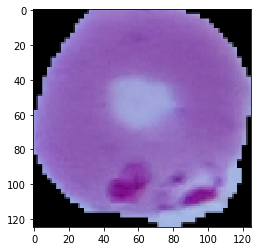

In [19]:
sample_img = data[0][300]
plt.imshow(sample_img)

(46, 64)
2944


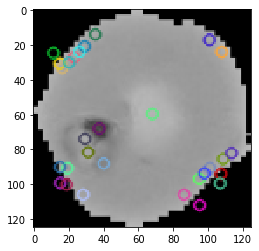

In [85]:
sample_img = data[0][103]
image =cv2.cvtColor(sample_img,cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SURF_create()
surf = cv2.xfeatures2d.SURF_create()

kp, descriptors = sift.detectAndCompute(image,None)
print(descriptors.shape)
print(descriptors.flatten().size)
def sortresponse(kp1):
    return kp1.response
kp.sort(key=sortresponse,reverse=True)
# kp[::-1][0].response
kp = kp[0:30]
gray = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY)
copy = cv2.drawKeypoints(gray,kp, outImage = None)
plt.imshow(copy[:, :, [2, 1, 0]])

In [6]:
def sortresponse1(kp1):
    return kp1[0].response

def calculate_histogram(images, model,n,num_of_kp):

    feature_vectors=[]

    for image in images :

        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        #SIFT extraction
        sift = cv2.xfeatures2d.SURF_create()
        kp, descriptors = sift.detectAndCompute(image,None)
        #classification of all descriptors in the model
        z = zip(kp,descriptors)
        z=list(z)
        z.sort(key=sortresponse1,reverse=True)
        descriptors = [x[1] for x in z]
        descriptors = descriptors[0:num_of_kp]
        predict_kmeans = model.predict(descriptors)
        #calculates the histogram
        hist, bin_edges = np.histogram(predict_kmeans, bins = n)
        #histogram is the feature vector
        feature_vectors.append(hist)

    feature_vectors=np.asarray(feature_vectors)

    return np.array(feature_vectors)

In [85]:
def data_processing(num_of_clusters=10,num_of_kp=40):
    sift_keypoints = []
    for image in x_train :
        image = change_contrast(image)
        image= image_cleanup(image)
        image = remove_noisy_regions(image)
#         image =cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        sift = cv2.xfeatures2d.SURF_create()
        kp, descriptors = sift.detectAndCompute(image,None)
        z = zip(kp,descriptors)
        z=list(z)
        z.sort(key=sortresponse1,reverse=True)
        descriptors = [x[1] for x in z]
        descriptors = descriptors[0:num_of_kp]
        sift_keypoints.append(descriptors)


    sift_keypoints = np.concatenate(sift_keypoints, axis=0)
    kmeans = KMeans(n_clusters = num_of_clusters).fit(sift_keypoints)
    print(sift_keypoints.shape)
    return kmeans

def create_features(kmeans,x_train,x_test,num_of_clusters=10,num_of_kp=40):
    x_feat_train = calculate_histogram(x_train, kmeans,num_of_clusters,num_of_kp)
    x_feat_test = calculate_histogram(x_test, kmeans,num_of_clusters,num_of_kp)
    return (x_feat_train,x_feat_test)

In [30]:
kmeans = data_processing()

(32382, 64)


In [31]:
(x_feat_train,x_feat_test) = create_features(kmeans,x_train,x_test)

In [15]:
x_feat_train[0]

array([14,  5,  0,  0,  3,  1,  2,  1,  8,  1])

In [23]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000)
rf.fit(x_feat_train, y_train);

y_pred = rf.predict(x_feat_test)
accuracy_score(y_pred, y_test)
# y_pred

ValueError: Expected 2D array, got 1D array instead:
array=[14.  5.  0. ...  0.  0.  0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [16]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import RandomForestClassifier
kmeans = MiniBatchKMeans(n_clusters=10,batch_size=22)
acc=[]
rf = RandomForestClassifier(n_estimators = 10000, warm_start=True)
def data_processing1(kmeans,x_train,num_of_clusters=10,num_of_kp=40):
    sift_keypoints = []
    for image in x_train :

        image =cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        sift = cv2.xfeatures2d.SURF_create()
        kp, descriptors = sift.detectAndCompute(image,None)
        z = zip(kp,descriptors)
        z=list(z)
        z.sort(key=sortresponse1,reverse=True)
        descriptors = [x[1] for x in z]
        descriptors = descriptors[0:num_of_kp]
        sift_keypoints.append(descriptors)


    sift_keypoints = np.concatenate(sift_keypoints, axis=0)
    kmeans = kmeans.partial_fit(sift_keypoints)
    print(sift_keypoints.shape)
    return kmeans

for i in range(22):
    print('='*10+' '*5+str(i)+' '*5+'='*10)
    data = load_dataset("./Data/train/", ["Parasitized", "Uninfected"],500*i)
    test_data = load_dataset("./Data/test/", ["Parasitized", "Uninfected"],500*i)

    y_train = np.concatenate([np.ones(len(data[0])), np.zeros(len(data[1]))])
    y_test = np.concatenate([np.ones(len(test_data[0])), np.zeros(len(test_data[1]))])

    x_train = np.concatenate(data)
    x_test = np.concatenate(test_data)
    
    kmeans = data_processing1(kmeans,x_train)
    (x_feat_train,x_feat_test) = create_features(kmeans,x_train,x_test)
    rf.fit(x_feat_train, y_train);

    y_pred = rf.predict(x_feat_test)
    a = accuracy_score(y_pred, y_test)
    print('Accuracy = '+str(a)+'-'*10)
    acc.append(a)
    

==========     0     ==========
0 images encountered error
0 images encountered error
(32382, 64)
Accuracy = 0.828----------
==========     1     ==========
0 images encountered error
0 images encountered error
(32474, 64)


/home/ronak/Projects/Malaria-Parasite-Detection/feature_extraction/lib/python3.6/site-packages/sklearn/ensemble/forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Accuracy = 0.858----------
==========     2     ==========
0 images encountered error
0 images encountered error
(32394, 64)


/home/ronak/Projects/Malaria-Parasite-Detection/feature_extraction/lib/python3.6/site-packages/sklearn/ensemble/forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Accuracy = 0.824----------
==========     3     ==========
0 images encountered error
0 images encountered error
(32163, 64)


/home/ronak/Projects/Malaria-Parasite-Detection/feature_extraction/lib/python3.6/site-packages/sklearn/ensemble/forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Accuracy = 0.835----------
==========     4     ==========
0 images encountered error
0 images encountered error
(31996, 64)


/home/ronak/Projects/Malaria-Parasite-Detection/feature_extraction/lib/python3.6/site-packages/sklearn/ensemble/forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Accuracy = 0.85----------
==========     5     ==========
0 images encountered error
0 images encountered error
(31978, 64)


/home/ronak/Projects/Malaria-Parasite-Detection/feature_extraction/lib/python3.6/site-packages/sklearn/ensemble/forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Accuracy = 0.849609375----------
==========     6     ==========
0 images encountered error
0 images encountered error
(32294, 64)


/home/ronak/Projects/Malaria-Parasite-Detection/feature_extraction/lib/python3.6/site-packages/sklearn/ensemble/forest.py:307: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [7]:
data = load_dataset("./Data/train/", ["Parasitized", "Uninfected"])
test_data = load_dataset("./Data/test/", ["Parasitized", "Uninfected"])

y_train = np.concatenate([np.ones(len(data[0])), np.zeros(len(data[1]))])
y_test = np.concatenate([np.ones(len(test_data[0])), np.zeros(len(test_data[1]))])

x_train = np.concatenate(data)
x_test = np.concatenate(test_data)

0 images encountered error
0 images encountered error


In [95]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_feat_train, y_train)
y_pred = logreg.predict(x_feat_test)
accuracy_score(y_pred, y_test)

/home/ronak/Projects/Malaria-Parasite-Detection/feature_extraction/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8496666666666667

In [96]:
clf = svm.LinearSVC(multi_class='ovr',max_iter=100000)
clf.fit(x_feat_train, y_train)

y_pred = clf.predict(x_feat_test)
accuracy_score(y_pred, y_test)

0.8413333333333334

In [17]:
def change_contrast(image,alpha = 1.5,beta=25):
    # Contrast control (1.0-3.0)
    # Brightness control (0-100)
    adjusted = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted

def image_cleanup(image):
    blurred = cv2.GaussianBlur(image, (3, 3), cv2.BORDER_DEFAULT)
    thresh = cv2.threshold(blurred, 186, 250, cv2.THRESH_BINARY)[1]
    return thresh
def remove_noisy_regions(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) 
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
    mask = cv2.erode(gray, element, iterations = 50)
    mask = cv2.dilate(mask, element, iterations = 50)
    element = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
    mask = cv2.erode(gray, element, iterations = 1)
    mask = cv2.dilate(mask, element, iterations = 1)
    mask = cv2.erode(mask, element)
    gray = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)
    return gray

def preprocess(image):
    i1 = change_contrast(image,1.97,17)
    i2 = image_cleanup(i1)
    img = remove_noisy_regions(i2)
    h,s,v = cv2.split(img)
    ab = cv2.subtract(h,s)
#     th, threshed = cv2.threshold(s, 100, 255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    return ab

def find_contours_and_centers(img_input):
    img, contours_raw, hierarchy = cv2.findContours(img_input, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours = [i for i in contours_raw]
    contour_centers = []
    
    for idx, c in enumerate(contours):
        M = cv2.moments(c)
        try:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        except:
            cX = int(M["m10"] / (M["m00"] + 0.0001))
            cY = int(M["m01"] / (M["m00"] + 0.0001))
        samp_bounds = cv2.boundingRect(c)
        contour_centers.append(((cX,cY), samp_bounds))
    contour_centers = sorted(contour_centers, key=lambda x: x[0])

    return (contours, contour_centers)

In [97]:
data = load_dataset("./Data/train/", ["Parasitized", "Uninfected"])
test_data = load_dataset("./Data/test/", ["Parasitized", "Uninfected"])

y_train = np.concatenate([np.ones(len(data[0])), np.zeros(len(data[1]))])
y_test = np.concatenate([np.ones(len(test_data[0])), np.zeros(len(test_data[1]))])

x_train = np.concatenate(data)
x_test = np.concatenate(test_data)

kmeans = data_processing()
(x_feat_train,x_feat_test) = create_features(kmeans,x_train,x_test)
x=[]
y=[]
for i in range(len(x_train)):
    im_processed = preprocess(x_train[i])
    conts, cents = find_contours_and_centers(im_processed)

#     x_feat_train[i] = np.append(x_feat_train[i],[len(cents)])
    mm = list(x_feat_train[i])
    mm.append(len(cents))
    x.append(mm)
    
for i in range(len(x_test)):
    im_processed = preprocess(x_test[i])
    conts, cents = find_contours_and_centers(im_processed)
#     x_feat_test[i] = np.append(x_feat_test[i],[len(cents)])

    mm = list(x_feat_test[i])
    mm.append(len(cents))
    y.append(mm)

0 images encountered error
0 images encountered error
(29314, 64)


In [63]:
a=[]
a.append(list(x_feat_train[0]).append(11))
a
# x_feat_train
l=list(x_feat_train[0]).append(11)
# l.append(11)
l
len(x)

1

In [98]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000)

rf.fit(np.asarray(x), y_train)

y_pred = rf.predict(np.asarray(y))
accuracy_score(y_pred, y_test)

0.93

In [95]:
import pandas as pd
dd = pd.read_csv('answers.csv')
k=0
count=0
for i in dd.Label:
    if(i==y_pred[k]):
        count+=1

In [96]:
# count/len(dd.Label)

0.44045368620037806